In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.3 MB/s 
     |████████████████████████████████| 4.0 MB 13.1 MB/s 
     |████████████████████████████████| 128 kB 78.3 MB/s 
     |████████████████████████████████| 110 kB 75.4 MB/s 
     |████████████████████████████████| 62 kB 1.8 MB/s 
     |████████████████████████████████| 112 kB 21.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew,norm
import matplotlib.pyplot as plt
from datetime import date, timedelta
import holidays
import sklearn
import seaborn as sns

In [ ]:
start_date = date(2018, 12, 20) 
end_date = date(2019, 12, 20)    

delta = end_date - start_date   # returns timedelta

for i in range(delta.days + 1):
    start_date_1 = start_date + timedelta(days=i)
    end_date = start_date.replace(start_date.year +1) + timedelta(days=i)
    #print( start_date_1, end_date) 

in_holidays = holidays.HolidayBase()
#trading holidays in the year 2018,2019,2020
in_holidays.append(['25-12-2018','04-03-2019','21-03-2019','17-04-2019','19-04-2019','01-05-2019','05-06-2019','12-08-2019','15-08-2019','02-09-2019','10-09-2019','02-10-2019','08-10-2019','28-10-2019','12-11-2019','25-12-2019','21-02-2020','10-03-2020','02-04-2020','06-04-2020','10-04-2020','14-04-2020','01-05-2020','25-05-2020','02-10-2020','16-11-2020','30-11-2020','25-12-2020'])


In [ ]:
#tickers = list of mutual funds
tickers = ['DRSK','HYXF','HYLB','GHYB','FALN','HYG','JNK','SMH','BAB','IUSG','QQQ','ILCG','VOOG','MGK','GVIP','ONEQ','IWY','FDMO','QGRO','RPG','AGTHX','VGTSX','FCNTX']


DSR_Values = {} #dictionary to save mutual funds name and the DSR value
Sharpe_Ratios =[] 

for ticker in tickers:
    count = 0

    A =[]
    
    df =  pd.DataFrame()

    data_list = []

    date = 'DD-MM-YYYY'

    for i in range(delta.days + 1):
        start_date_1 = start_date + timedelta(days=i)
        end_date_1 = start_date.replace(start_date.year +1) + timedelta(days=i)

        if start_date_1.weekday() < 5 and start_date_1 not in in_holidays: # 6-saturday, 7-sunday

            #print( start_date_1, end_date_1)
            data = yf.download(ticker, start=start_date_1, end = end_date_1)  #downloading the data from yahoo

            data[f'Daily_Return{start_date_1}'] = data['Adj Close'].pct_change() 
            data = data.dropna() 
            data = data.reindex(axis = 0) 

            n = len(data[f'Daily_Return{start_date_1}']) 

            sum = 0
            for x in data[f'Daily_Return{start_date_1}']:
                sum = sum + x
            mean = sum / n #calculating the mean

            dev = 0
            for x in data[f'Daily_Return{start_date_1}']:
                dev = dev + ((x - mean)**2 ) 

            variance = dev / (n - 1) 
            std = variance**(1/2) #standard deviation

            risk_free_rate = 0.0004 

            daily_sharpe_ratio = (mean - risk_free_rate) / s

            #annualizing the sharpe ratio
            sr = n**(1/2) * daily_sharpe_ratio
            count +=1
            A.append(sr) #list of sharpe ratio
            val = data[f"Daily_Return{start_date_1}"]
            data_list.append(val.tolist()) #appending a list of daily_returns to data_list
            
      
            print(sr)
    
    Sharpe_Ratios.append(A) #list of daily sharpe ratios of mutual funds
    print(count)
    sum = 0
    for i in range(len(A)):
      sum += A[i]
    mean = sum / len(A) #mean of sharpe_ratios

    sum_2 = 0 
    for i in range(len(A)):
      sum_2 += (mean - A[i])**2

    variance = sum_2 / len(A)
    std = variance**(1/2) #standard deviations of sharpe_ratios

    #print (mean,variance)

    skewness = skew(A, axis=0, bias=True) #skewness of sharpe_ratios
    gamma_4 = kurtosis(A, axis=0, bias=True) #kurtosis of sharpe ratios
    gamma = 0.5772

    #Converting the Data_list into dataframe
    data = pd.DataFrame(data_list)
    data = data.dropna(axis = 1)
    
    #correlation matrix of the dataframe
    corr_matrix = data.corr()
    m = corr_matrix.shape[1]

    #calculating the independent trial
    sum = 0
    for i in range(m):
        for j in range(i+1,m):
            sum = sum + corr_matrix[i][j]
    rho = (2*sum)/(m*(m-1))

    independent_trial = rho + (1-rho)*m

    N = int(independent_trial)

   

    # Finding the SR_0
    e = 2.71828
    SR_0 = std*((1-gamma)*norm.ppf((1-(1/N)))+ gamma*norm.ppf((1-(1/N)*(1/e))))

    
    
    # Finding The Deflated Sharpe Ratio
    sr = max(A)
    dsr = norm.cdf(((sr-SR_0)*((n-1)**(1/2)))/(1 - skewness*sr + (gamma_4-1)*(sr**2)*(1/4))**(1/2)) 
    DSR_Values[ticker] = dsr
    print(ticker,dsr,sr)


Streaming output truncated to the last 5000 lines.
[*********************100%***********************]  1 of 1 completed
1.3124436399173154
[*********************100%***********************]  1 of 1 completed
1.3310345041289582
[*********************100%***********************]  1 of 1 completed
1.4107264106563213
[*********************100%***********************]  1 of 1 completed
1.4567942829816887
[*********************100%***********************]  1 of 1 completed
1.591033482178046
[*********************100%***********************]  1 of 1 completed
1.5497097765353494
[*********************100%***********************]  1 of 1 completed
1.6338573699325925
[*********************100%***********************]  1 of 1 completed
1.5342551462651934
[*********************100%***********************]  1 of 1 completed
1.5718922365036847
[*********************100%***********************]  1 of 1 completed
1.5732728189902452
[*********************100%***********************]  1 of 1 completed
1

In [ ]:
#converting dictionary DSR_Values into dataframe data
data = pd.DataFrame.from_dict(DSR_Values,orient = 'index')
data

,0
DRSK,9.999174e-01
HYXF,5.086791e-02
HYLB,3.584353e-03
GHYB,1.333411e-02
FALN,1.169149e-02
HYG,2.836637e-03
JNK,2.594077e-03
SMH,1.000000e+00
BAB,1.000000e+00
IUSG,1.000000e+00


In [ ]:
#converting the list Sharpe_Ratios into DataFrame SR
SR = pd.DataFrame(Sharpe_Ratios) 
SR1= SR.transpose()

tickers = ['DRSK','HYXF','HYLB','GHYB','FALN','HYG','JNK','SMH','BAB','IUSG','QQQ','ILCG','VOOG','MGK','GVIP','ONEQ','IWY','FDMO','QGRO','RPG','AGTHX','VGTSX','FCNTX']
i = 0


#renaming all the column indexes
for ticker in tickers:
  SR1.rename(columns = {i:ticker}, inplace = True)
  i+=1

SR1

,DRSK,HYXF,HYLB,GHYB,FALN,HYG,JNK,SMH,BAB,IUSG,...,MGK,GVIP,ONEQ,IWY,FDMO,QGRO,RPG,AGTHX,VGTSX,FCNTX
0,0.312178,0.891261,0.834696,0.862053,1.176488,0.754610,0.778068,1.712804,0.192135,1.315595,...,1.482605,1.132630,1.407207,1.464309,1.079739,1.460036,1.186642,1.157512,0.939984,1.208498
1,0.297656,0.865474,0.906094,0.985212,1.271055,0.829194,0.870051,1.818606,0.227869,1.529615,...,1.717190,1.380636,1.629950,1.689177,1.261462,1.669507,1.410057,1.373688,1.101938,1.432718
2,0.286213,1.059012,1.069975,1.148392,1.379540,1.003421,1.050031,1.949122,0.136501,1.753814,...,1.898819,1.560765,1.772809,1.897623,1.443179,1.806516,1.618771,1.549681,1.172028,1.577092
3,0.312967,1.058954,0.780203,0.852398,1.161648,0.715556,0.760103,1.780922,0.236029,1.485404,...,1.640362,1.296409,1.524192,1.631896,1.157464,1.556099,1.357492,1.270738,0.981688,1.301382
4,0.371826,0.982009,0.834611,0.955760,1.238098,0.761312,0.807635,1.757755,0.283219,1.473748,...,1.645334,1.280176,1.548091,1.630436,1.118764,1.518153,1.303874,1.259726,1.045151,1.299627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,0.508627,-0.180296,-0.244585,-0.228164,0.267606,-0.272090,-0.252388,0.980347,0.018860,0.651864,...,0.807678,0.875077,0.889090,0.776185,0.423917,0.742476,0.550593,0.797861,0.095782,0.670011
248,0.504391,-0.174029,-0.240911,-0.224441,0.259798,-0.271869,-0.249493,1.002560,0.014686,0.691635,...,0.837480,0.896942,0.927610,0.809425,0.459614,0.768521,0.582850,0.811718,0.124746,0.691479
249,0.509831,-0.185945,-0.261659,-0.237082,0.237245,-0.290919,-0.267374,1.009499,0.026399,0.702112,...,0.849958,0.909164,0.936567,0.824162,0.476544,0.796177,0.586727,0.816730,0.144701,0.710546
250,0.473460,-0.177996,-0.250045,-0.235466,0.254517,-0.279322,-0.257821,0.995890,0.020772,0.703160,...,0.851247,0.907517,0.939705,0.827806,0.505881,0.816945,0.597072,0.837042,0.165909,0.712311


In [ ]:
tickers = ['DRSK','HYXF','HYLB','GHYB','FALN','HYG','JNK','SMH','BAB','IUSG','QQQ','ILCG','VOOG','MGK','GVIP','ONEQ','IWY','FDMO','QGRO','RPG','AGTHX','VGTSX','FCNTX']

#printing the maximum Sharpe Ratios of each fund
for i in tickers:
  print(i,max(SR1[i]))

DSR_Values

DRSK 1.023489015001634
HYXF 1.0590124484357106
HYLB 1.0699750458171908
GHYB 1.148391766819718
FALN 1.379540345939872
HYG 1.0034210289045273
JNK 1.0500314871394592
SMH 2.023209963052686
BAB 1.4513411424839437
IUSG 1.7538143053857036
QQQ 1.807022580771125
ILCG 1.7363680914619422
VOOG 1.7663806914701397
MGK 1.9044635451188971
GVIP 1.5607645435816446
ONEQ 1.7728089609440585
IWY 1.915356580398802
FDMO 1.443179050258218
QGRO 1.8065159628826641
RPG 1.6187713023058194
AGTHX 1.5496805478373368
VGTSX 1.172028005470102
FCNTX 1.5770915908640888


{'DRSK': 0.9999174026667416,
 'HYXF': 0.050867913892908845,
 'HYLB': 0.0035843528629496023,
 'GHYB': 0.013334108017786802,
 'FALN': 0.011691493012045868,
 'HYG': 0.0028366369500285185,
 'JNK': 0.0025940774527359197,
 'SMH': 1.0,
 'BAB': 1.0,
 'IUSG': 0.9999999999999216,
 'QQQ': 0.999999999999994,
 'ILCG': 0.999999999991311,
 'VOOG': 1.0,
 'MGK': 1.0,
 'GVIP': 0.7488559085916084,
 'ONEQ': 0.9999999961424075,
 'IWY': 1.0,
 'FDMO': 0.9496161343518261,
 'QGRO': 0.9999980452009374,
 'RPG': 0.9987971157762756,
 'AGTHX': 0.9960146828448311,
 'VGTSX': 3.575888825439301e-07,
 'FCNTX': 0.9999773822542071}

Checking for the formula used in the code by taking the example of the paper

In [ ]:
e = 2.71828   #euler's constant
gamma = 0.5772   #
N = 100
variance = 1/2
std = variance**(1/2)
n = 1250
skewness = -3
gamma_4 = 10
SR_0 = ((std)*(1/(250)**(1/2)))*((1-gamma)*norm.ppf((1-(1/N)))+ gamma*norm.ppf((1-(1/N)*(e)**(-1))))
#print(SR_0)
sr = 2.5/(250)**(1/2)
# Finding The Deflated Sharpe Ratio
dsr = norm.cdf(((sr-SR_0)*((n-1)**(1/2)))/(1 - skewness*sr + (gamma_4-1)*(sr**2)*(1/4))**(1/2)) 

print(dsr,SR_0)

0.9003981026924524 0.11317174815288898


Plotting

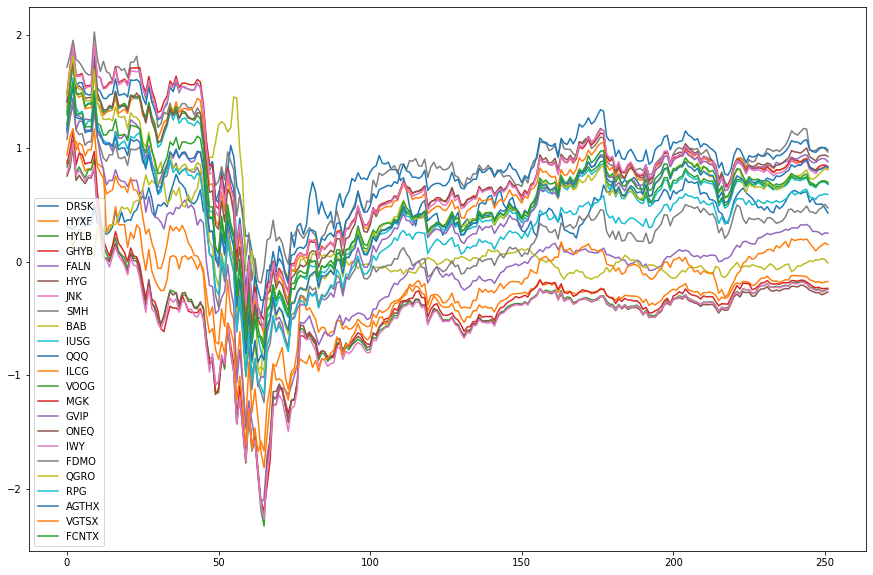

In [ ]:
SR1.plot(figsize=(15, 10), legend=True)

plt.savefig('plot.png')

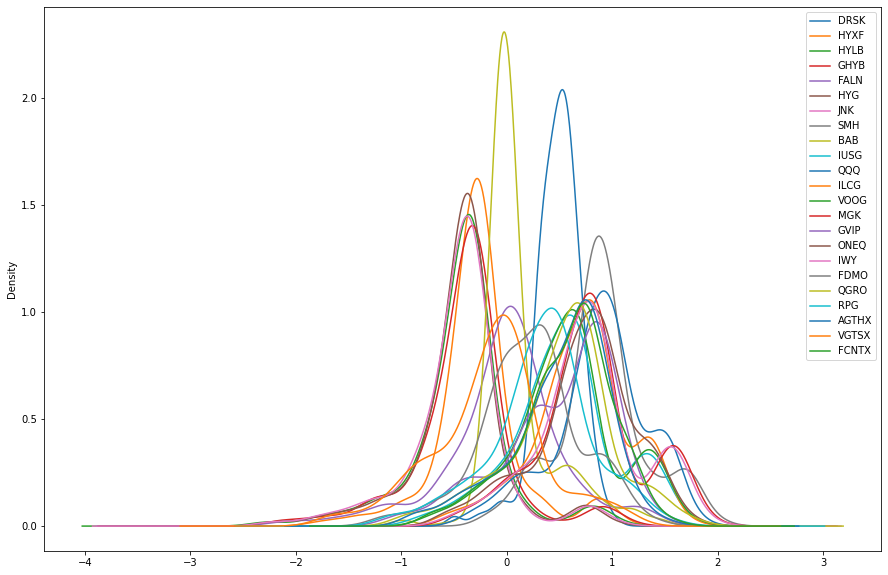

In [ ]:
SR1.plot(kind = 'density', figsize=(15, 10), legend=True)
plt.savefig('density.png')

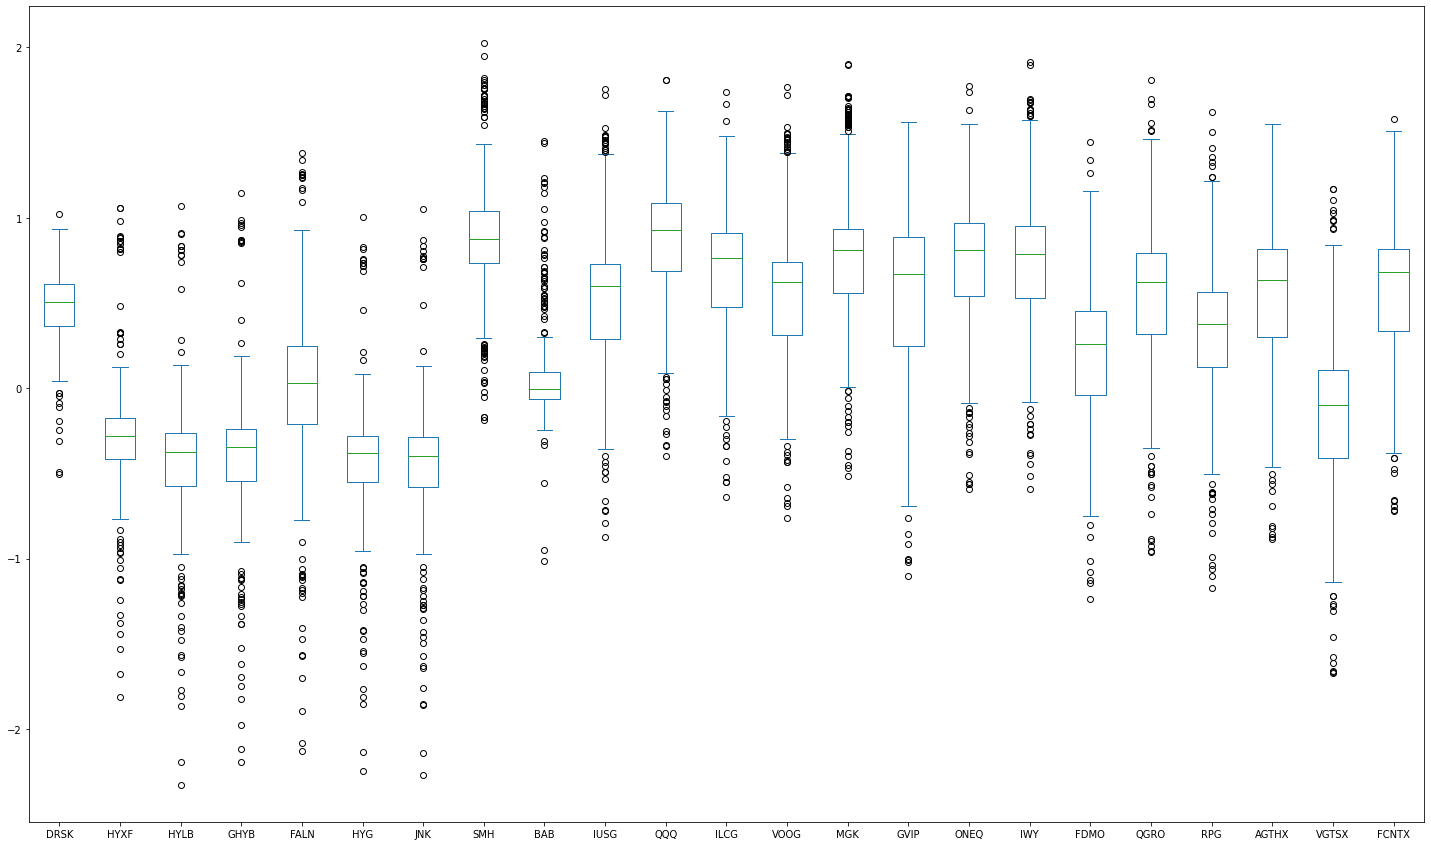

In [ ]:
SR1.plot(kind = 'box', figsize=(25, 15), legend=True)
plt.savefig('box.png')

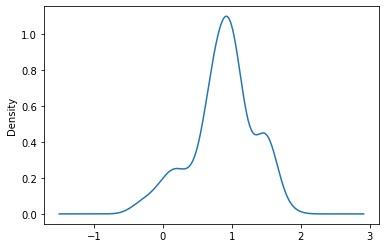

In [ ]:
SR1['QQQ'].plot(kind = 'density')

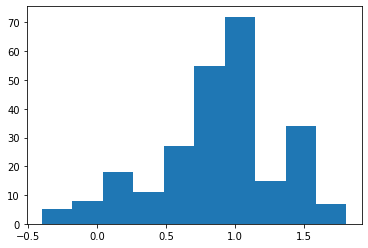

In [ ]:
plt.hist(SR1['QQQ'])
plt.show()